# Neural Networks: Foundation for Deep-learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.linear_model import LogisticRegressionCV

In [2]:
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generate Non-linear seperable dataset and using our previous classifiers for classifying data

#### Dataset 1: Spiral-dataset

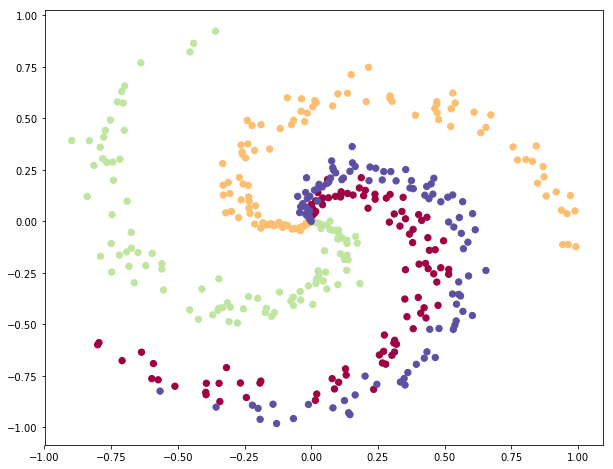

In [58]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

### Dataset2: 

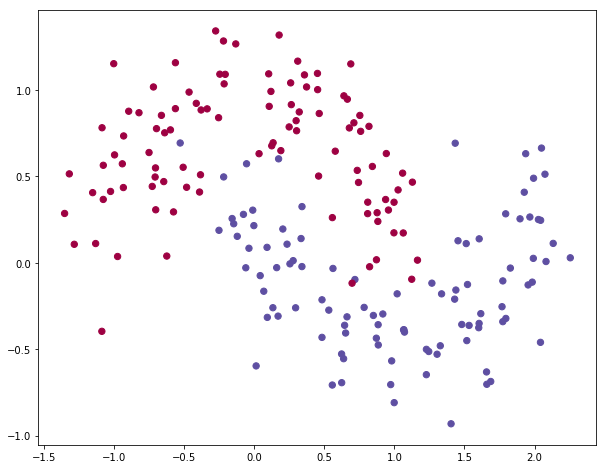

In [46]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

### Logistic regression classifier

In [59]:
clf = LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [60]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5,1,'Logistic Regression')

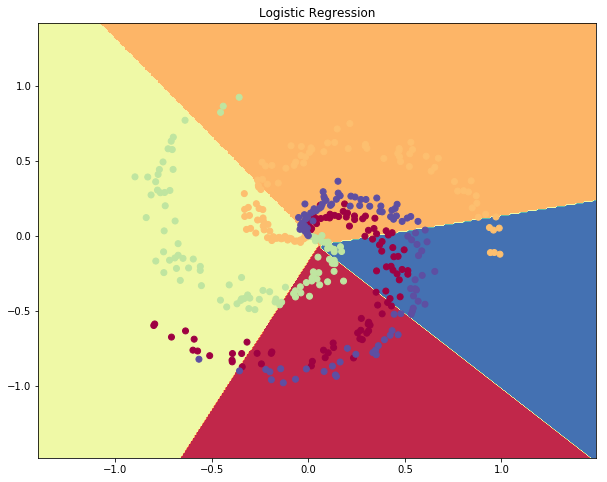

In [61]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

# Building and Training a Neural Network

<td>
<p style="text-align:center;"> Architecture Diagram for Neural Networks with single hidden layer</p>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg" />
 </td>

### Non-Linear Activation Functions
$$\begin{eqnarray}
sigmoid(x) &=& &\frac{1}{1+ {e}^{-x}} \\
tanh(x) &=& &\frac{{e}^{x}- {e}^{-x}}{{e}^{x}+ {e}^{-x}}
\end{eqnarray}$$

### Softmax Function
$$\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$

### Forward propogation

$$\begin{eqnarray}
z_{1} &=& &x\cdot W_{1} &+& b_{1} \\
a_{1} &=& &tanh(z_{1}) \\
z_{2} &=& &a_{1}\cdot W_{2} &+& b_{2} \\
\hat{y} &=& &\sigma({z_{2}})
\end{eqnarray}$$

### Loss function
<math>\begin{align}
    J(\mathbf{w})\ &=\ \frac1N\sum_{n=1}^N H(p_n,q_n)\ =\ -\frac1N\sum_{n=1}^N\ \bigg[y_n  \log \hat y_n + (1 - y_n)  \log (1 - \hat y_n)\bigg]\
\end{align}</math>

#### Defining parameters

In [64]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 4 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
learning_rate = 0.001 # learning rate for gradient descent
regularization_param = 0.01 # regularization strength

#### Loss function

In [65]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += regularization_param/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

#### Generate prediction

In [66]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


In [67]:
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += regularization_param * W2
        dW1 += regularization_param * W1

        # Gradient descent parameter update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

Loss after iteration 0: 1.513034
Loss after iteration 1000: 0.966339
Loss after iteration 2000: 0.906298
Loss after iteration 3000: 0.896874
Loss after iteration 4000: 0.896825
Loss after iteration 5000: 0.896910
Loss after iteration 6000: 0.896947
Loss after iteration 7000: 0.896972
Loss after iteration 8000: 0.896997
Loss after iteration 9000: 0.897020
Loss after iteration 10000: 0.897038
Loss after iteration 11000: 0.897051
Loss after iteration 12000: 0.897058
Loss after iteration 13000: 0.897059
Loss after iteration 14000: 0.897056
Loss after iteration 15000: 0.897048
Loss after iteration 16000: 0.897037
Loss after iteration 17000: 0.897024
Loss after iteration 18000: 0.897010
Loss after iteration 19000: 0.896994


Text(0.5,1,'Decision Boundary for hidden layer size 3')

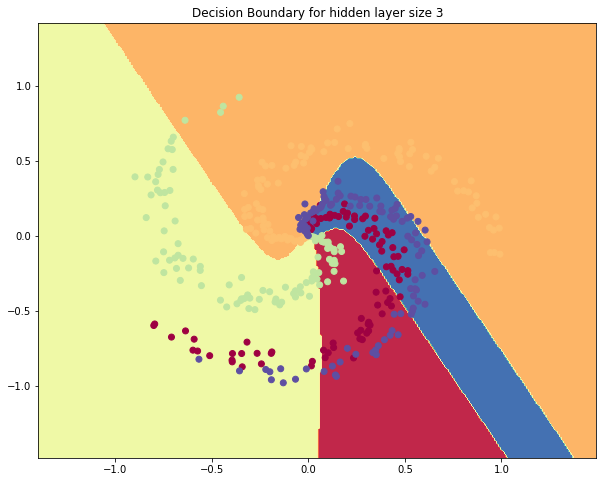

In [68]:
# Build a model with a 3-dimensional hidden layer
model = build_model(2, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

7it [01:12, 10.36s/it]


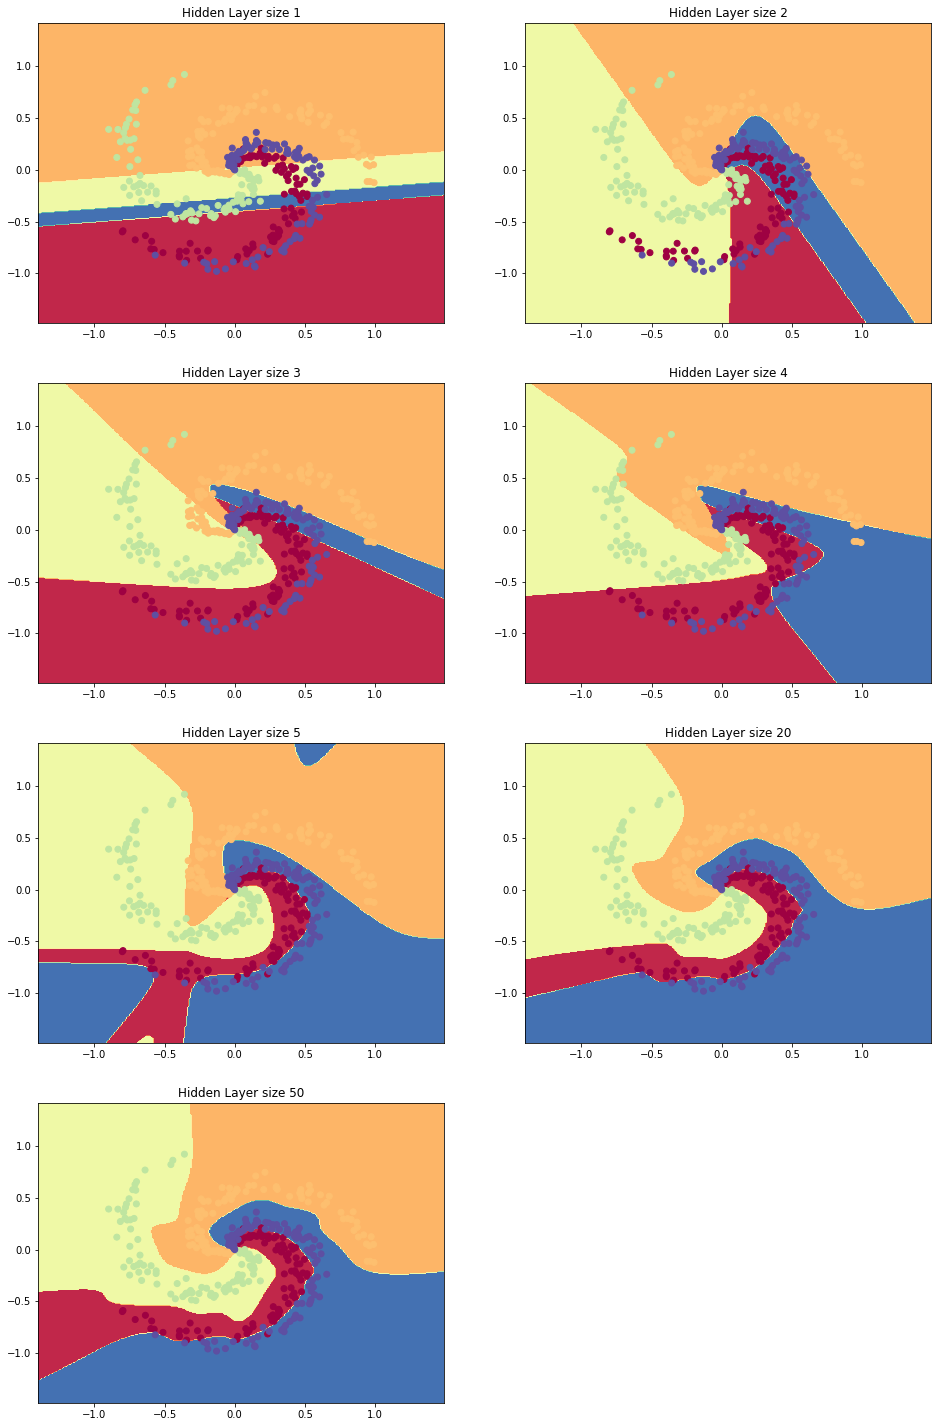

In [69]:
from tqdm import tqdm
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in tqdm(enumerate(hidden_layer_dimensions)):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

#### References
* Generating dataset using sklearn: https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/
* The Linear Separability Problem: Some Testing Methods, IEEE TRANSACTIONS ON NEURAL NETWORKS, VOL. 17, NO. 2, MARCH 2006: http://sci2s.ugr.es/keel/pdf/specific/articulo/IEEETNN06.pdf